In [1]:
import cv2 
import os 
import json
import csv
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

from p_tqdm import p_map
from pathlib import Path
from glob import glob 
from tqdm import tqdm 

import sys 
sys.path.append('../')

from module.utils import imread, imfindcircles, findProjectiveTransform, str2array, adjust_gamma, find_valid_dest_circles, adaptiveThreshold_3ch
from module.utils import getEdgePixels, imgradient, getGrayImage, chaccum
from module.disp_measure import displacement_measure

In [2]:
# 센서 번호 입력

sensor_num = str('164')

# 센서 번호에 따른 이미지 리스트 호출
img_folder = 'imgs'
img_list = glob(os.path.join(img_folder, 'Img_' + sensor_num + '*.jpg'))

# 센서 번호에 따른 세부 파라메터 호출 
with open('../params.json') as param_config_json : 
    param_config = json.load(param_config_json)
    
params = param_config[sensor_num]


min_rad = params.get("min_rad",70)
max_rad = params.get("max_rad",100)
sensitivity = params.get("sensitivity",0.98)
gamma = float(params.get("gamma", 1.0))
binarization = params.get("binarization", 0)

params

{'min_rad': 70,
 'max_rad': 90,
 'sensitivity': 0.98,
 'src_img': 'Img_164_20200901_160100.jpg'}

In [3]:
result_folder = os.path.join("imgs", 'result', sensor_num)
Path(result_folder).mkdir(parents=True, exist_ok=True)
img_list.sort()
    
for img_path in tqdm(img_list) : 

    img = imread(img_path)
    img_basename = os.path.basename(img_path)
    img_copy = img.copy()


    if gamma != 1.0 :  
        img = adjust_gamma(img, gamma=gamma)

    if binarization : 
        img = adaptiveThreshold_3ch(img, min_rad)

    centers, r_estimated, metric = imfindcircles(img, 
                                                 [params['min_rad'], params['max_rad']],
                                                sensitivity = sensitivity)
    circles = np.concatenate((centers, r_estimated[:,np.newaxis]), axis = 0).T
    circles = np.squeeze(circles)
    
    if len(circles) > 4 : 
        circles = find_valid_dest_circles(circles)

    if circles is not None: 
        # Convert the circle parameters a, b and r to integers. 
        circles = np.uint16(np.around(circles)) 
        if circles.ndim ==1 : 
            circles = circles[np.newaxis, :]
        for pt in circles: 
            a, b, r = pt[0], pt[1], pt[2]   
            # Draw the circumference of the circle. 
            cv2.circle(img_copy, (a, b), r, (0, 255, 0), 2) 
            # Draw a small circle (of radius 1) to show the center. 
            cv2.circle(img_copy, (a, b), 1, (0, 0, 255), 3) 

        cv2.imwrite(os.path.join(result_folder, img_basename), cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    else:
        print("circles is not detected")

100%|██████████| 24/24 [01:03<00:00,  2.64s/it]


100%|██████████| 24/24 [01:02<00:00,  2.62s/it]


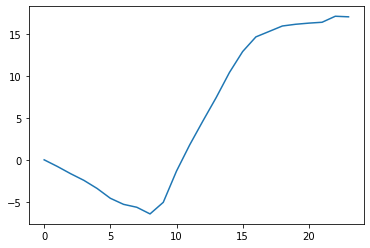

In [4]:
result = [] # 결과를 저장할 result list 

# 최초 source image에서 circle detection 수행 
src_img = cv2.imread(img_list[0])

if gamma != 1.0 :  
    src_img = adjust_gamma(src_img, gamma=gamma)

if binarization : 
    src_img = adaptiveThreshold_3ch(src_img, min_rad)

centers, r_estimated, metric = imfindcircles(src_img, 
                                             [min_rad, max_rad],
                                            sensitivity = sensitivity)

src_circles = np.concatenate((centers, r_estimated[:,np.newaxis]), axis = 0).T
src_circles = np.squeeze(src_circles)
# src_img = cv2.imread(img_list[0])
# 호출된 이미지 목록에서 displacement_measure 수행 
for img_path in tqdm(img_list): 
    dest_img = cv2.imread(img_path)
       
    '''
    변경사항
    1. 함수 이름을 displacement_measure로 변경하였습니다. 
    2. displacement_measure에 필요한 변수는 아래와 같습니다. 
        1) dest_img : 측정 대상 이미지 
        2) src_img : 고정점 이미지 
        3) src_circles : 고정점 이미지에서 탐지된 원들의 중심 좌표 및 지름 (고정점 이미지에서 변위 재측정 방지용)
        4) min_rad : 최소 원의 지름 크기 / max_rad : 최대 원의 지름 크기 
    '''
    disp, dest_circles = displacement_measure(dest_img,
                                              src_img,
                                              params = params,
                                              src_circles = src_circles
                                              )
    
    result.append(disp)
#     for dest_circle in dest_circles : 
#         dest_img = cv2.circle(dest_img, tuple(np.asarray(dest_circle[:2], dtype =np.int64)), int(dest_circle[2]), (0,255,0), thickness=1, lineType=8, shift=0)
#     cv2.imwrite(img_path[:-4] + '_with_circles_result.jpeg', dest_img)
    
collect_rslt = []
for rslt in result : 
    collect_rslt.append(rslt[0])
    
plt.plot(np.array(collect_rslt))